#  **Final Project - Demographic Analysis of the Academy Award Nominations**
*Notebook III*

The Oscar Award dataset - Film network

---

> Authors: Sara Kartalovic, Bogdan Milovanovic,  Tarja Savonen<br>
> Date: 19/01/2022 <br>
> Course : Network Science <br>
> Teacher : Tomaso Erseghe <br>
> Co-Teachers : Lejla Dzanko

In [91]:
# Imports

import os
import pandas as pd
import numpy as np
import math as math
from operator import itemgetter

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns 

import itertools
import networkx as nx

from scipy.optimize import curve_fit
from scipy.stats import linregress

In [92]:
# Mount Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [160]:
def degree_freq(G, degree_direction):
    n_nodes = len(G.nodes)
    if degree_direction=='in':
        k_list = np.array([G.in_degree[i] for i in range(n_nodes)])
    elif degree_direction=='out':
        k_list = np.array([G.out_degree[i] for i in range(n_nodes)])
    else:
        k_list = np.array([val for (node, val) in G.degree()])
        
    dmax=max(k_list)+1
    freq= [ 0 for d in range(dmax) ] #[0,0,0,,,,,,0]
    for d in k_list:
        freq[d] += 1
    return (freq, k_list)

plt.show()

def plot_plot(G, degree_direction):
    freq, k_list = degree_freq(G, degree_direction)
       
    mean_degree = round(np.mean(k_list),3) # mean value of degree list
    std_degree = round(np.std(k_list),3) # stdev of degree list
    figure(figsize=(7, 5))

    plt.plot(range(len(freq)),freq, '.')
    plt.xticks(range(0,max(k_list),5))
    plt.xlabel(degree_direction+"-degree, $K_{%s}$"%degree_direction,size=12)
    plt.ylabel('Number of nodes',size=12)
    plt.title(degree_direction+'-degree distribution, $P_{k_{%s}}$'%degree_direction,size=14)
    s = 'n_nodes: '+str(len(k_list))+'\nMean degree: '+str(mean_degree)+'\nSTDEV degree: '+str(std_degree)
    
    # some useful tricks to plot text in the place of legend!!
    plt.plot([],[],label=s)
    legend = plt.legend(handlelength=0, handletextpad=0, fancybox=True,loc='best')
    plt.show()


def logPk(logk,logc,gamma):
    return logc - gamma*logk

def plotnfit_Pk(G, degree_direction):    
    freq, k_list = degree_freq(G, degree_direction)
    # k is list of all the degrees present.
    
    k_initial = 1 #we reject all K < K_initial
    # k= [80.....475] for in degree. 
    k = np.array(range(k_initial,max(k_list)+1)) # applying assumption
    # consider only the frequencies for K>=80 where freq=counts for k values of (0,1,2,3,....) in that order
    Pk = np.array(freq[k_initial:])

    # remove zeros from Pk, clean the data since we are applying log function.
    Pk_new = Pk[Pk>0] #Pk[True, True, False, .......]
    # remove all degrees that have 0 frequency
    k_new = k[Pk>0]

    # apply log to do log fitting instead of power law fitting
    x = np.log(k_new)
    y = np.log(Pk_new)
    params,cov = curve_fit(logPk,x,y) # cov is the covariance matrix
    logc = params[0]
    gamma = params[1]

    y_fit = logPk(x,*params)

    figure(figsize=(7, 5))

    plt.loglog(range(len(freq)), freq, '.')
    plt.loglog(np.exp(x),np.exp(y_fit))
    
    # aesthetics
    plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
    plt.grid(linestyle='--',alpha=0.5)
    
    # print info on the graph
    s = 'Reject all K < '+str(k_initial)+'\n$\gamma = $ '+str(round(gamma,3))+'\nlog(C) = '+str(round(logc,3))
    # some useful tricks to plot text in the place of legend!!
    plt.plot([],[],label=s)
    legend = plt.legend(handlelength=0, handletextpad=0, fancybox=True,loc='best')
    
    plt.xlabel(degree_direction+"-degree, $k_{%s}$"%degree_direction,size=12)
    plt.ylabel("$P_{k_{%s}}$"%degree_direction,size=12)
    plt.title('log-log plot of %s-degree distribution \nand fit $P_{k_{%s}} = C  K^{-\gamma}_{%s}$'
              %(degree_direction,degree_direction,degree_direction),size=14)
    
    plt.show()

def plot_degree_distr(G, degree_direction):
    plt.figure()
    
    plt.subplot(1,2,1)
    plot_barplot(G, degree_direction)
    
    plt.subplot(1,2,2)
    plotnfit_Pk(G, degree_direction)
    
    #plt.tight_layout()
    plt.show()

# Building Network

In [94]:
oscar_filtered = pd.read_csv('/content/drive/MyDrive/NS/Original Filtered Data/the_oscar_award_filtered.csv')

In [95]:
# Create dataframe that consists of only 5 categories

people_nominated_df = oscar_filtered.loc[(oscar_filtered['category'] == 'ACTOR') | (oscar_filtered['category'] == 'ACTRESS') 
                                        | (oscar_filtered['category'] == 'ACTOR IN A SUPPORTING ROLE') | (oscar_filtered['category'] == 'ACTRESS IN A SUPPORTING ROLE')
                                        | (oscar_filtered['category'] == 'DIRECTING')]
#people_nominated_df = oscar_filtered

In [96]:
#initialize an empty dict
unique_films = {}

for idx, row in people_nominated_df.iterrows():
#for row in oscar.film:
  films = [row['film']]
  for film in films:
    #if the word is encountered for the first time add to dict as key and set its value to 0
    unique_films.setdefault(film,0)
    #increase the value (b.e the count) of the word by 1 every time it is encountered
    unique_films[film] += 1

In [97]:
uf_df = pd.DataFrame.from_dict(unique_films, orient='index').reset_index()
uf_df.rename(columns = {'index':'Film', 0:'Count'}, inplace=True)
uf_df.sort_values(by=['Count'], ascending=False, inplace=True)
#uf_df.to_csv("unique_films.csv")

In [98]:
# Create dictionary- {film: list of actors}

#initialize an empty dict
film_name_dict = {}

for idx, row in people_nominated_df.iterrows():
#for row in oscar.film:
  people = [row['name']]
  films = [row['film']]

  for film in films:
    for person in people:
      #if the word is encountered for the first time add to dict as key and set its value to 0
      if film not in film_name_dict.keys():
        film_name_dict.setdefault(film,[person])
      else:
        film_name_dict[film].append(person)

In [99]:
# Create dataframe from dictionary
film_name_df = pd.DataFrame.from_dict(film_name_dict, orient='index').reset_index()
film_name_df.rename(columns= {'index':'Movie', 0:'Name1',1:'Name2',2:'Name3', 3: 'Name4', 4:'Name5', 5:'Name6', 6:'Name7', 7:'Name8'}, inplace= True)
film_name_df = film_name_df.fillna('0')

In [100]:
# Create network

G = nx.Graph()
edge_attribute_dict = {}

for film, names in film_name_dict.items():
  G.add_node(film)
  for name in names:
    for film2, names2 in film_name_dict.items():
      if (name in names2) and (names2 != names):
        G.add_edge(film, film2)
        film_tuple = tuple((film, film2))
        if film_tuple not in edge_attribute_dict:
          edge_attribute_dict.setdefault(film_tuple,0)
        else:
          edge_attribute_dict[film_tuple] +=1

In [101]:
print(nx.info(G))

Graph with 1251 nodes and 2195 edges


In [13]:
#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted = []
for edges, weigth in edge_attribute_dict.items():
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted.append((edges[0],edges[1],weigth))

G.add_weighted_edges_from(up_weighted)

In [ ]:
# Save edges
nx.write_weighted_edgelist(G, "./film_name_5_cat_edgelist.csv", delimiter=",")

# Save nodes
nf_df = film_name_df.copy()
nf_df.drop(columns=[column for column in nf_df.columns if column!='Movie'], inplace=True)
nf_df.rename(columns={'Movie':'Label'}, inplace=True)
nf_df["Id"] = nf_df["Label"]
nf_df.to_csv("film_name_5_cat_nodelist.csv")

# Network Analysis


## Degree distribution

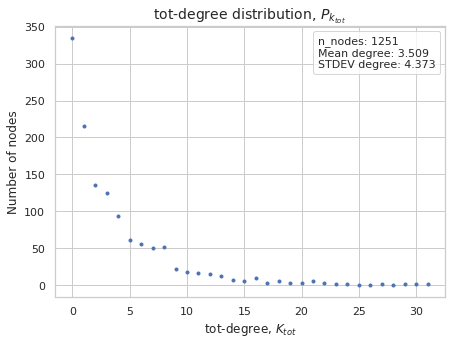

In [161]:
plot_plot(G,'tot')

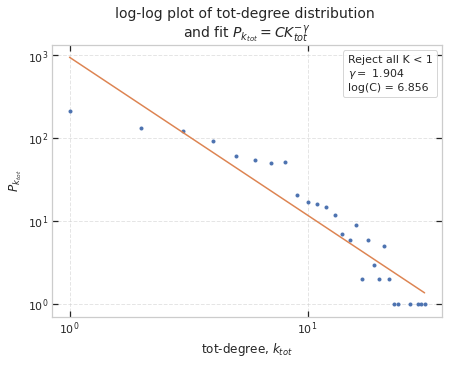

In [162]:
plotnfit_Pk(G,'tot')

## Shorthest Path (NO WEIGHTS)

(0.0, 20.0)

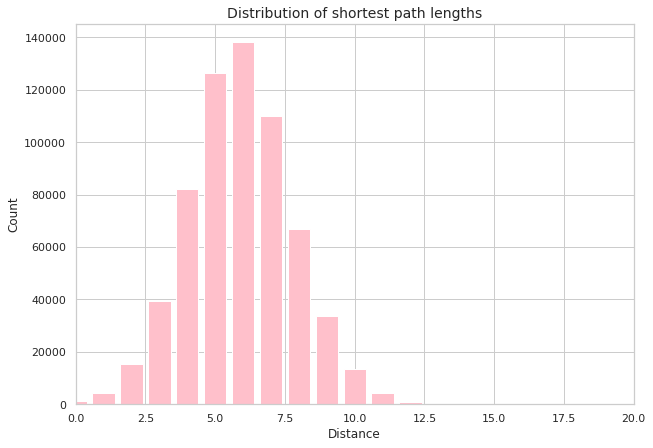

In [136]:
# Find path lengths
length_source_target = dict(nx.shortest_path_length(G, weight = 'weight'))

# Convert dict of dicts to flat list
all_shortest = sum([
list(length_target.values())
for length_target
in length_source_target.values()],
[])
# Calculate integer bins
high = max(all_shortest)
bins = [-0.5 + i for i in range(high + 2)]

# Plot histogram
plt. figure(figsize=(10,7))
plt.hist(all_shortest, bins=bins, rwidth=0.8, color = 'pink')
plt.title("Distribution of shortest path lengths", size=14)
plt.xlabel("Distance", size=12)
plt.ylabel("Count", size=12)
plt.xlim(0,20)

## Centrality measurements

### Page Rank

In [103]:
page_rank = nx.pagerank(G, alpha = 0.8, weight = 'weight') 

sorted_page_rank = sorted(page_rank.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by Page rank:")
for b in sorted_page_rank[:10]:
    print(b)

Top 10 nodes by Page rank:
('Kramer vs. Kramer', 0.0034348043877613327)
('Doubt', 0.0033476296289877746)
('Julia', 0.003227594171490496)
('Ironweed', 0.003122987572822596)
('The Godfather', 0.0030458506215014576)
('All about Eve', 0.002920862632309234)
('The Deer Hunter', 0.0028895113411692343)
('The Life of Emile Zola', 0.002865255497517335)
('Lincoln', 0.002839866651445562)
('Reds', 0.0028087287150101144)


### Betweenness centrality

In [105]:
betweenness_dict = nx.betweenness_centrality(G, weight = 'weight') # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G, weight = 'weight') # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

In [106]:
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by betweenness centrality:")
for b in sorted_betweenness[:10]:
    print(b)

Top 10 nodes by betweenness centrality:
('Julia', 0.03761228090831507)
("Prizzi's Honor", 0.034663448977661306)
('A Star Is Born', 0.031708753868828356)
('Ironweed', 0.02879140398932718)
('Reds', 0.026581342693704147)
('All about Eve', 0.02622179876971923)
('Bonnie and Clyde', 0.026164129299569235)
('Doubt', 0.0257871612818305)
("Gentleman's Agreement", 0.024532830623819165)
('The African Queen', 0.024503514729076786)


In [107]:
sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by eigenvector centrality:")
for b in sorted_eigenvector[:10]:
    print(b)

Top 10 nodes by eigenvector centrality:
('Ironweed', 0.31119403676700763)
('Kramer vs. Kramer', 0.28623265008675275)
('Doubt', 0.2797837180973919)
('The Deer Hunter', 0.27821309514552056)
('Silkwood', 0.2730287489536915)
('Out of Africa', 0.2700554218027408)
('August: Osage County', 0.26899545681470105)
('Adaptation', 0.2662994142505687)
("The French Lieutenant's Woman", 0.15076989411986494)
("Sophie's Choice", 0.15076989411986494)


### Closeness Centrality

In [127]:
close_centrality = nx.closeness_centrality(G) #does not need weights

sorted_centrality = sorted(close_centrality.items(), key=itemgetter(1), reverse=True)
print("Top 10 nodes by closeness centrality:")
for d in sorted_centrality[:10]:
    print(d)

Top 10 nodes by closeness centrality:
("Prizzi's Honor", 0.15355734625870948)
('Ironweed', 0.1514469076785181)
('Julia', 0.150413293768546)
('The African Queen', 0.15036867398398102)
('A Star Is Born', 0.1485182537357164)
('The Deer Hunter', 0.14756704512372634)
('On Golden Pond', 0.14748117544370093)
('Terms of Endearment', 0.14544987087517933)
('Kramer vs. Kramer', 0.14544987087517933)
("They Shoot Horses, Don't They?", 0.14519988541965054)


In [125]:
closeness = pd.DataFrame.from_dict(sorted_centrality) #closeness centrality
closeness.columns =['Node', 'Closeness centrality'] 
closeness['Closeness centrality'] = (closeness['Closeness centrality'] - min(closeness['Closeness centrality']))/(max(closeness['Closeness centrality'])- min(closeness['Closeness centrality']))

eigenvec = pd.DataFrame.from_dict(sorted_eigenvector)
eigenvec.columns =['Node', 'Eigenvector centrality'] 
eigenvec['Eigenvector centrality'] = (eigenvec['Eigenvector centrality'] - min(eigenvec['Eigenvector centrality']))/(max(eigenvec['Eigenvector centrality'])- min(eigenvec['Eigenvector centrality']))


betweenness = pd.DataFrame.from_dict(sorted_betweenness)
betweenness.columns =['Node', 'Betweenness centrality'] 
betweenness['Betweenness centrality'] = (betweenness['Betweenness centrality'] - min(betweenness['Betweenness centrality']))/(max(betweenness['Betweenness centrality'])- min(betweenness['Betweenness centrality']))

page_rank = pd.DataFrame.from_dict(sorted_page_rank)
page_rank.columns =['Node', 'Page Rank centrality'] 
page_rank['Page Rank centrality'] = (page_rank['Page Rank centrality'] - min(page_rank['Page Rank centrality']))/(max(page_rank['Page Rank centrality'])- min(page_rank['Page Rank centrality']))

closeness = closeness[0:5]
eigenvec = eigenvec[0:5]
betweenness = betweenness[0:5]
page_rank = page_rank[0:5]

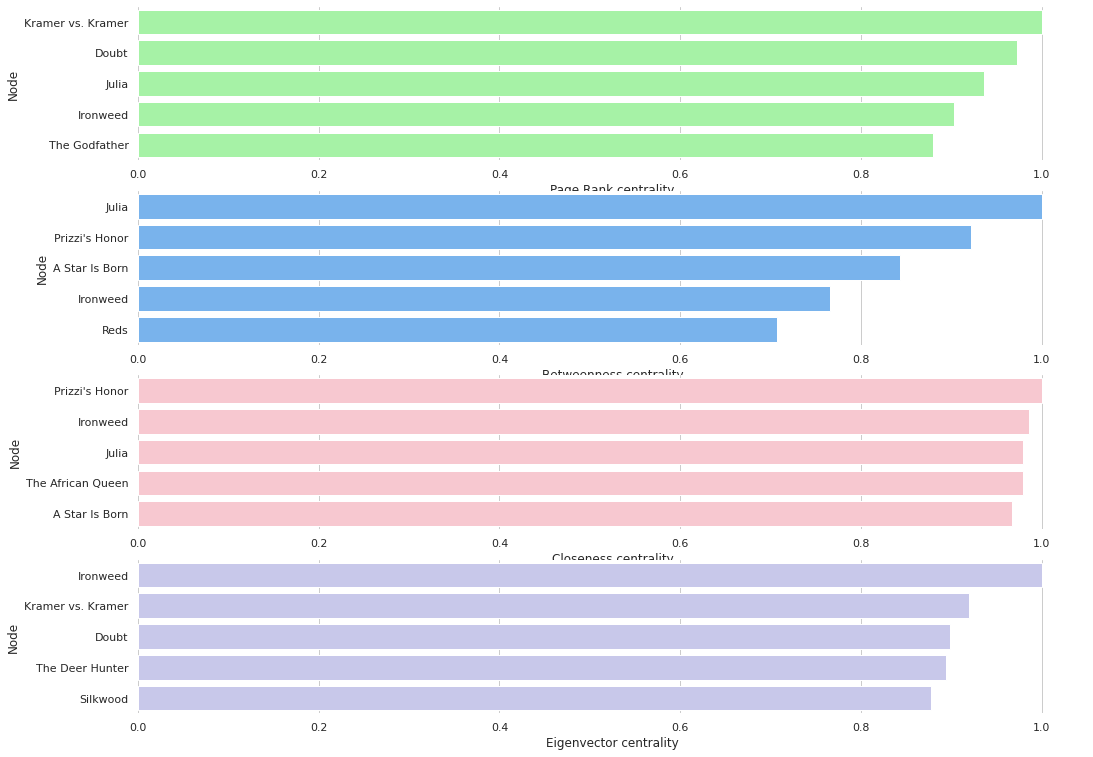

In [137]:
# Initialize the matplotlib figure

fig, (ax3, ax4, ax5, ax6) = plt.subplots(4,figsize=(17, 13) )

sns.set(style="whitegrid")

sns.barplot(x='Closeness centrality', y="Node",data=closeness,
            color="pink", orient = 'h',order=closeness.sort_values('Closeness centrality', ascending=False)['Node'] , ax = ax5)


sns.barplot(x='Eigenvector centrality', y="Node",data=eigenvec,
            color='#c2c2f0', orient = 'h',order=eigenvec.sort_values('Eigenvector centrality', ascending=False)['Node'] , ax = ax6)

sns.barplot(x= 'Betweenness centrality', y="Node",data=betweenness,
            color='#66b3ff', orient = 'h',order=betweenness.sort_values('Betweenness centrality', ascending=False)['Node'] , ax = ax4)

sns.barplot(x='Page Rank centrality', y="Node",data=page_rank,
            color="#99ff99", orient = 'h',order=page_rank.sort_values('Page Rank centrality', ascending=False)['Node'] , ax = ax3)

sns.despine(left=True, bottom=True)

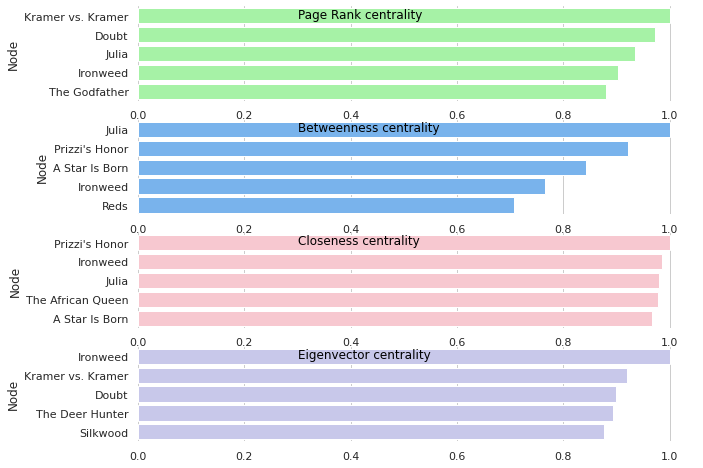

In [159]:
# Initialize the matplotlib figure

fig, (ax3, ax4, ax5, ax6) = plt.subplots(4,figsize=(10, 8) )

sns.set(style="whitegrid")

sns.barplot(x='Closeness centrality', y="Node",data=closeness,
            color="pink", orient = 'h',order=closeness.sort_values('Closeness centrality', ascending=False)['Node'] , ax = ax5)
ax5.text(0.3, 0.1,'Closeness centrality', c = "Black")
ax5.xaxis.label.set_visible(False)

sns.barplot(x='Eigenvector centrality', y="Node",data=eigenvec,
            color='#c2c2f0', orient = 'h',order=eigenvec.sort_values('Eigenvector centrality', ascending=False)['Node'] , ax = ax6)
ax6.text(0.3, 0.10,'Eigenvector centrality', c = "Black")
ax6.xaxis.label.set_visible(False)

sns.barplot(x= 'Betweenness centrality', y="Node",data=betweenness,
            color='#66b3ff', orient = 'h',order=betweenness.sort_values('Betweenness centrality', ascending=False)['Node'] , ax = ax4)
ax4.text(0.3, 0.10,'Betweenness centrality', c = "Black")
ax4.xaxis.label.set_visible(False)

sns.barplot(x='Page Rank centrality', y="Node",data=page_rank,
            color="#99ff99", orient = 'h',order=page_rank.sort_values('Page Rank centrality', ascending=False)['Node'] , ax = ax3)
ax3.text(0.3, 0.10,'Page Rank centrality', c = "Black")
ax3.xaxis.label.set_visible(False)

sns.despine(left=True, bottom=True)